In [2]:
import os
import pandas as pd
import argparse
import warnings
from utils import *
from torch import nn
import copy
from tqdm import tqdm
import random 
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import Rectangle
import numpy as np
from train import train_parameter
from model_parameter import ANN_gaussian,DRO_layer_dynamic_price,Intra_schdule_layer,Determinisitic_layer
from model_parameter import Combined_deterministic_parameter_dynamic_price,Combined_model_parameter_dynamic_price
from test_parameter import Evaluation_original_model_parameter

from online_parameter import *
warnings.filterwarnings("ignore")

In [3]:
set_seed(42)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [4]:
parser_train = argparse.ArgumentParser()
parser_train.add_argument('--seq_len', type=int, default=24*7)
parser_train.add_argument('--pred_len', type=int, default=24)
parser_train.add_argument('--label_len', type=int, default=0)
parser_train.add_argument('--train_length', type=int, default=17376)
parser_train.add_argument('--target', type=str, default='target')
parser_train.add_argument('--scale', type=bool, default=True)
parser_train.add_argument('--inverse', type=bool, default=True)
parser_train.add_argument('--num_epochs', type=int, default=1000)
parser_train.add_argument('--mode', type=str, default='no-parameter')
parser_train.add_argument('--quantiles', type=list, default=[0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95])
parser_train.add_argument('--lr', type=float, default=5e-4)
parser_train.add_argument('--patience', type=int, default=20)
parser_train.add_argument('--hidden_layers', type=list, default=[128,128,128])
parser_train.add_argument('--e2e_num_epochs', type=int, default=5)
parser_train.add_argument('--e2e_ft_lr', type=float, default=1e-6)
parser_train.add_argument('--e2e_lr', type=float, default=1e-7)#1e-7
parser_train.add_argument('--ft_lr', type=float, default=1e-4)
parser_train.add_argument('--batch_size', type=int, default=16)
parser_train.add_argument('--device', type=str, default='cuda:0' if torch.cuda.is_available() else 'cpu')
parser_train.add_argument('--epsion_p', type=float, default=1e1)
parser_train.add_argument('--epsion_l', type=float, default=1e1)
parser_train.add_argument('--metric_list', type=list, default=['pinball_loss','winkler_score_0.1','MAE','RMSE'])


parser_train.add_argument('--N_g', type=int, default=3)
parser_train.add_argument('--T', type=int, default=24)
parser_train.add_argument('--N', type=int, default=25)
parser_train.add_argument('--x_max', type=int, default=3000)
parser_train.add_argument('--x_min', type=int, default=0)
parser_train.add_argument('--z_pos_max', type=list, default=[500,700,800])
parser_train.add_argument('--z_neg_max', type=list, default=[500,700,800])
parser_train.add_argument('--z_pos_min', type=int, default=0)
parser_train.add_argument('--z_neg_min', type=int, default=0)
parser_train.add_argument('--r_neg', type=int, default=1000)
parser_train.add_argument('--r_pos', type=int, default=1000)
parser_train.add_argument('--alpha', type=list, default=[0.03 for i in range(24)]+[0.028 for i in range(24)]+[0.032 for i in range(24)])
parser_train.add_argument('--alpha_pos', type=list, default=[0.02 for i in range(24)]+[0.018 for i in range(24)]+[0.022 for i in range(24)])
parser_train.add_argument('--alpha_neg', type=list, default=[0.01 for i in range(24)]+[0.009 for i in range(24)]+[0.011 for i in range(24)])

parser_train.add_argument('--rho_z_pos', type=list, default=[0.05 for i in range(24)]+[0.045 for i in range(24)]+[0.055 for i in range(24)])
parser_train.add_argument('--rho_z_neg', type=list, default=[0.01 for i in range(24)]+[0.008 for i in range(24)]+[0.012 for i in range(24)])

parser_train.add_argument('--rho_r_pos', type=list, default=[0.1 for i in range(24)])
parser_train.add_argument('--rho_r_neg', type=list, default=[0.05 for i in range(24)])
# True+1：（e2e ft lr：1e-6），（e2e lr: 1e-7）
# True+2: （e2e ft lr：1e-7），（e2e lr: 1e-6）
parser_train.add_argument('--price_ratio_large', type=float, default=4)
parser_train.add_argument('--price_ratio_small', type=float, default=0.8)
parser_train.add_argument('--flag_dynamic_price', type=bool, default=True)
parser_train.add_argument('--flag_dynamic_mode', type=int, default=1)
parser_train.add_argument('--upper_quantiles', type=float, default=0.95)
parser_train.add_argument('--lower_quantiles', type=float, default=0.05)
parser_train.add_argument('--epsion', type=float, default=1)

args_train = parser_train.parse_args(args=[])

In [5]:
train_load_data,train_load_loader=get_load_data(args_train,flag='train')
val_load_data,val_load_loader=get_load_data(args_train,flag='val')
test_load_data,test_load_loader=get_load_data(args_train,flag='test')

train_pv_data,train_pv_loader=get_pv_data(args_train,flag='train')
val_pv_data,val_pv_loader=get_pv_data(args_train,flag='val')
test_pv_data,test_pv_loader=get_pv_data(args_train,flag='test')

combined_train_data,combined_train_loader,combined_val_data,combined_val_loader,combined_test_data,combined_test_loader,combined_fine_tune_data,combined_fine_tune_loader = obtain_price(args_train,train_pv_data,train_load_data,val_pv_data,val_load_data,test_pv_data,test_load_data)


../Data/GEF_data/data.csv
(143, 24, 11)
(143, 24)
../Data/GEF_data/data.csv
(36, 24, 11)
(36, 24)
../Data/GEF_data/data.csv
(544, 24, 11)
(544, 24)
../Data/PV/PV_1h.csv
(143, 13, 11)
(143, 13)
../Data/PV/PV_1h.csv
(36, 13, 11)
(36, 13)
../Data/PV/PV_1h.csv
(544, 13, 11)
(544, 13)
Test data is not shuffled
Test data is not shuffled


### load forecasting

In [6]:
input_size=train_load_data.X.shape[-1]
output_size=1
set_seed(46)
model_load=ANN_gaussian(input_size=input_size, hidden_layers=args_train.hidden_layers, output_size=output_size).to(device)
train_parameter(args_train, model_load, train_load_loader, val_load_loader,dir_best_model='../Model/best_ann_load.pt')

Epoch 0, Train Loss: 1.4152996391057968
Epoch [1/1000] Train Loss: 1.4153 Val Loss: 1.2417
Epoch [2/1000] Train Loss: 1.1134 Val Loss: 0.9931
Epoch [3/1000] Train Loss: 0.9002 Val Loss: 0.7750
Epoch [4/1000] Train Loss: 0.7128 Val Loss: 0.5903
Epoch [5/1000] Train Loss: 0.5498 Val Loss: 0.5351
Epoch [6/1000] Train Loss: 0.4284 Val Loss: 0.4383
Epoch [7/1000] Train Loss: 0.3685 Val Loss: 0.4292
Epoch [8/1000] Train Loss: 0.2693 Val Loss: 0.3755
Epoch [9/1000] Train Loss: 0.2586 Val Loss: 0.2195
Epoch [10/1000] Train Loss: 0.2187 Val Loss: 0.2500
Epoch 10, Train Loss: 0.16997601906768978
Epoch [11/1000] Train Loss: 0.1700 Val Loss: 0.1754
Epoch [12/1000] Train Loss: 0.1184 Val Loss: 0.1692
Epoch [13/1000] Train Loss: 0.0751 Val Loss: 0.0497
Epoch [14/1000] Train Loss: 0.0672 Val Loss: 0.0723
Epoch [15/1000] Train Loss: 0.0586 Val Loss: 0.2115
Epoch [16/1000] Train Loss: 0.0579 Val Loss: 0.0459
Epoch [17/1000] Train Loss: -0.0036 Val Loss: 0.0089
Epoch [18/1000] Train Loss: -0.0211 Val Lo

### pv forecasting

In [7]:
input_size=train_pv_data.X.shape[-1]
output_size=1
set_seed(46)
model_pv=ANN_gaussian(input_size=input_size, hidden_layers=args_train.hidden_layers, output_size=output_size).to(device)
train_parameter(args_train, model_pv, train_pv_loader, val_pv_loader,dir_best_model='../Model/best_ann_pv.pt')

Epoch 0, Train Loss: 1.389242559671402
Epoch [1/1000] Train Loss: 1.3892 Val Loss: 1.2900
Epoch [2/1000] Train Loss: 1.1666 Val Loss: 1.0370
Epoch [3/1000] Train Loss: 0.9723 Val Loss: 0.8070
Epoch [4/1000] Train Loss: 0.7918 Val Loss: 0.6031
Epoch [5/1000] Train Loss: 0.6579 Val Loss: 0.4116
Epoch [6/1000] Train Loss: 0.4423 Val Loss: 0.2690
Epoch [7/1000] Train Loss: 0.3371 Val Loss: 0.2684
Epoch [8/1000] Train Loss: 0.2461 Val Loss: 0.2556
Epoch [9/1000] Train Loss: 0.2222 Val Loss: 0.2207
Epoch [10/1000] Train Loss: 0.1785 Val Loss: 0.1750
Epoch 10, Train Loss: 0.15771293872967362
Epoch [11/1000] Train Loss: 0.1577 Val Loss: 0.1882
Epoch [12/1000] Train Loss: 0.1531 Val Loss: 0.1449
Epoch [13/1000] Train Loss: 0.1114 Val Loss: 0.1646
Epoch [14/1000] Train Loss: 0.1159 Val Loss: 0.1449
Epoch [15/1000] Train Loss: 0.0794 Val Loss: 0.1180
Epoch [16/1000] Train Loss: 0.1013 Val Loss: 0.1583
Epoch [17/1000] Train Loss: 0.0993 Val Loss: 0.1234
Epoch [18/1000] Train Loss: 0.0453 Val Loss:

### Fine tune

In [8]:
determinisitic_opt_layer = Determinisitic_layer(args_train)
intra_opt_layer = Intra_schdule_layer(args_train)
dro_opt_layer = DRO_layer_dynamic_price(args_train)

In [9]:
model_org_deterministic =  Combined_deterministic_parameter_dynamic_price(determinisitic_opt_layer,intra_opt_layer,copy.deepcopy(model_pv), copy.deepcopy(model_load)).to(device)
model_org_deterministic.to(device)

Combined_deterministic_parameter_dynamic_price(
  (model_pv): ANN_gaussian(
    (hidden_layers): Sequential(
      (0): Linear(in_features=11, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): ReLU()
      (4): Linear(in_features=128, out_features=128, bias=True)
      (5): ReLU()
    )
    (distribution_presigma): Linear(in_features=128, out_features=1, bias=True)
    (distribution_mu): Linear(in_features=128, out_features=1, bias=True)
    (distribution_sigma): Softplus(beta=1, threshold=20)
  )
  (model_load): ANN_gaussian(
    (hidden_layers): Sequential(
      (0): Linear(in_features=11, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): ReLU()
      (4): Linear(in_features=128, out_features=128, bias=True)
      (5): ReLU()
    )
    (distribution_presigma): Linear(in_features=128, out_features=1, bias=True)
    (distribution_mu): Linear(i

In [10]:
model_org_dro =  Combined_model_parameter_dynamic_price(dro_opt_layer,intra_opt_layer,copy.deepcopy(model_pv), copy.deepcopy(model_load)).to(device)
model_org_dro.to(device)

Combined_model_parameter_dynamic_price(
  (model_pv): ANN_gaussian(
    (hidden_layers): Sequential(
      (0): Linear(in_features=11, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): ReLU()
      (4): Linear(in_features=128, out_features=128, bias=True)
      (5): ReLU()
    )
    (distribution_presigma): Linear(in_features=128, out_features=1, bias=True)
    (distribution_mu): Linear(in_features=128, out_features=1, bias=True)
    (distribution_sigma): Softplus(beta=1, threshold=20)
  )
  (model_load): ANN_gaussian(
    (hidden_layers): Sequential(
      (0): Linear(in_features=11, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): ReLU()
      (4): Linear(in_features=128, out_features=128, bias=True)
      (5): ReLU()
    )
    (distribution_presigma): Linear(in_features=128, out_features=1, bias=True)
    (distribution_mu): Linear(in_featur

In [11]:
solution_list_org_intra_deterministic, solution_list_org_ahead_deterministic, cost_org_deterministic =Evaluation_original_model_parameter(args_train, model_org_deterministic, combined_test_loader, train_pv_data.scaler_y,train_load_data.scaler_y)

In [12]:
solution_list_org_ahead_ideal, solution_list_org_intra_ideal, cost_org_ideal =Evaluation_original_model_parameter(args_train, model_org_deterministic, combined_test_loader,train_pv_data.scaler_y,train_load_data.scaler_y,mode='ideal')

In [13]:
solution_list_org_intra_dro, solution_list_org_ahead_dro, cost_org_dro, forecasts_pv_org, forecasts_load_org,targets_pv,targets_load=Evaluation_original_model_parameter(args_train, model_org_dro, combined_test_loader, train_pv_data.scaler_y,train_load_data.scaler_y,mode='dro')

--------------PV--------------
Pinball Loss: 55.20897534979204
Winkler Score_0.1: 932.7711498935381
MAE: 138.5817297979383
RMSE: 251.58294316221975
--------------Load--------------
Pinball Loss: 90.8590822940918
Winkler Score_0.1: 1227.6317269757633
MAE: 249.0726815706769
RMSE: 304.3075314760054
--------------PV--------------
Pinball Loss: 51.690486088644626
Winkler Score_0.1: 897.5979699500213
MAE: 133.0449572294764
RMSE: 230.10101574796587
--------------Load--------------
Pinball Loss: 108.48621771722922
Winkler Score_0.1: 1546.4646626088672
MAE: 297.4914793460288
RMSE: 343.56420650682776
--------------PV--------------
Pinball Loss: 49.99330800852468
Winkler Score_0.1: 899.5160185469371
MAE: 118.55419445364412
RMSE: 220.06527930104664
--------------Load--------------
Pinball Loss: 54.56800637617529
Winkler Score_0.1: 970.9607748369322
MAE: 135.78338322141244
RMSE: 166.16559740079265
--------------PV--------------
Pinball Loss: 58.81014242137065
Winkler Score_0.1: 895.4110104136536
MA

In [ ]:
combined_model =  Combined_model_parameter_dynamic_price(dro_opt_layer,intra_opt_layer,copy.deepcopy(model_pv), copy.deepcopy(model_load))
combined_model.to(device)
set_seed(42)
solution_list_ahead, solution_list_intra, cost_list, forecasts_pv,forecasts_load = Traditional_online_parameter(args_train, combined_model, combined_fine_tune_loader, combined_test_loader, train_pv_data.scaler_y,train_load_data.scaler_y)

New test batch 1
Accuracy after fine tune
--------------PV--------------
Pinball Loss: 55.20563433463349
Winkler Score_0.1: 933.5743873188214
MAE: 138.54288666012076
RMSE: 251.4651160509901
--------------Load--------------
Pinball Loss: 91.11935676508877
Winkler Score_0.1: 1231.1258222007339
MAE: 249.75713315453902
RMSE: 305.16852294997756


Test Objective: 2663.7802929191653
New test batch 2
Accuracy after fine tune
--------------PV--------------
Pinball Loss: 51.66252777410416
Winkler Score_0.1: 897.9373487840547
MAE: 132.88170696603677
RMSE: 229.91748263651277
--------------Load--------------
Pinball Loss: 111.68158681626322
Winkler Score_0.1: 1603.5286168977632
MAE: 305.0844138297279
RMSE: 352.3886507332942
Test Objective: 2472.046532942712
New test batch 3
Accuracy after fine tune
--------------PV--------------
Pinball Loss: 49.87900827541017
Winkler Score_0.1: 898.9669590316798
MAE: 118.04633713448605
RMSE: 219.4396069020175
--------------Load--------------
Pinball Loss: 53.50758096762626
Winkler Score_0.1: 989.1286481510551
MAE: 127.9309079186215
RMSE: 159.56888481508474
Test Objective: 2166.9026865699257
New test batch 4
Accuracy after fine tune
--------------PV--------------
Pinball Loss: 58.65138165996978
Winkler Score_0.1: 893.7641256584956
MAE: 154.50652703729563
RMSE: 288.54455424699745
--------------Load-----

In [ ]:
combined_model_e2e =  Combined_model_parameter_dynamic_price(dro_opt_layer,intra_opt_layer,copy.deepcopy(model_pv), copy.deepcopy(model_load))
combined_model_e2e.to(device)
set_seed(42)
solution_list_ahead_e2e, solution_list_intra_e2e,cost_list_e2e, forecasts_pv_e2e,forecasts_load_e2e = E2E_parameter(args_train, combined_model_e2e, combined_train_loader, combined_test_loader, train_pv_data.scaler_y,train_load_data.scaler_y)
solution_list_ahead_e2e_ecl,solution_list_intra_e2e, cost_list_e2e_ecl, forecasts_pv_e2e_ecl,forecasts_load_e2e_ecl = E2E_online_parameter(args_train, combined_model_e2e, combined_fine_tune_loader, combined_test_loader, train_pv_data.scaler_y,train_load_data.scaler_y)

e2e epoch: 0
e2e epoch: 1
e2e epoch: 2
Accuracy after fine tune
--------------PV--------------
Pinball Loss: 55.40769095956791
Winkler Score_0.1: 917.8149434771187
MAE: 139.54343165750782
RMSE: 255.57688883465175
--------------Load--------------
Pinball Loss: 83.51470232775067
Winkler Score_0.1: 1123.5647921123268
MAE: 229.6814922738379
RMSE: 279.2204475998937
Test Objective: 2652.692278482827
Accuracy after fine tune
--------------PV--------------
Pinball Loss: 52.09341792789131
Winkler Score_0.1: 889.4501180923385
MAE: 136.82268688308855
RMSE: 235.33689643448994
--------------Load--------------
Pinball Loss: 121.99919847315266
Winkler Score_0.1: 1811.021554175525
MAE: 328.7373111761076
RMSE: 378.03615974929465
Test Objective: 2528.3353491301873
Accuracy after fine tune
--------------PV--------------
Pinball Loss: 50.705142914774875
Winkler Score_0.1: 895.1318274755637
MAE: 120.96558515508579
RMSE: 229.08495614645085
--------------Load--------------
Pinball Loss: 58.099334522953605
Wi

In [ ]:
combined_model_online_e2e =  Combined_model_parameter_dynamic_price(dro_opt_layer,intra_opt_layer,copy.deepcopy(model_pv), copy.deepcopy(model_load))
combined_model_online_e2e.to(device)
set_seed(42)
solution_list_ahead_online_e2e,solution_list_intra_online_e2e, cost_list_online_e2e, forecasts_pv_online_e2e,forecasts_load_online_e2e = E2E_online_parameter(args_train, combined_model_online_e2e, combined_fine_tune_loader, combined_test_loader, train_pv_data.scaler_y,train_load_data.scaler_y)

New test batch 1


Accuracy after fine tune
--------------PV--------------
Pinball Loss: 55.15150094280457
Winkler Score_0.1: 933.2444105434386
MAE: 138.37893095292117
RMSE: 251.24276100959543
--------------Load--------------
Pinball Loss: 92.35624317691098
Winkler Score_0.1: 1248.9450600544926
MAE: 252.9197377514873
RMSE: 309.22344173885233
Test Objective: 2665.628367416053
New test batch 2
Accuracy after fine tune
--------------PV--------------
Pinball Loss: 51.62067354594846
Winkler Score_0.1: 897.3710027165232
MAE: 132.71329102090766
RMSE: 229.6794359411507
--------------Load--------------
Pinball Loss: 107.57009929496517
Winkler Score_0.1: 1530.5938365301017
MAE: 295.28557008872457
RMSE: 341.1354551509488
Test Objective: 2454.6349682023233
New test batch 3
Accuracy after fine tune
--------------PV--------------
Pinball Loss: 49.66308077922663
Winkler Score_0.1: 898.1943067483454
MAE: 117.69345493464334
RMSE: 217.3898203316443
--------------Load--------------
Pinball Loss: 53.269919022563684
Winkler 

In [ ]:
print('Cost Ideal',np.mean(cost_org_ideal))
print(np.mean(cost_org_deterministic))
print('Cost Original',np.mean(cost_org_dro))
print('Cost TCL',np.mean(cost_list))    
print('Cost E2E',np.mean(cost_list_e2e))
print('Cost ECL',np.mean(cost_list_online_e2e))
print('Cost E2E_ECL',np.mean(cost_list_e2e_ecl))

cost_dic={}
cost_dic['Ideal']=np.mean(cost_org_ideal)
cost_dic['Deterministic']=np.mean(cost_org_deterministic)
cost_dic['Original']=np.mean(cost_org_dro)
cost_dic['TCL']=np.mean(cost_list)
cost_dic['E2E']=np.mean(cost_list_e2e)
cost_dic['ECL']=np.mean(cost_list_online_e2e)
cost_dic['E2E_ECL']=np.mean(cost_list_e2e_ecl)
cost_df = pd.DataFrame(list(cost_dic.values()), index=cost_dic.keys(), columns=['Cost'])
cost_df.to_csv('../Result/parameter/Cost_'+str(int(args_train.flag_dynamic_price))+str(args_train.flag_dynamic_mode)+'.csv')


print('Cost decrease percent (vs original):',-(np.mean(cost_list_e2e_ecl)-np.mean(cost_org_dro))/np.mean(cost_org_dro)*100)
print('Cost decrease percent (vs TCL):',-(np.mean(cost_list_e2e_ecl)-np.mean(cost_list))/np.mean(cost_list)*100)
print('Cost decrease percent (vs E2E):',-(np.mean(cost_list_e2e_ecl)-np.mean(cost_list_e2e))/np.mean(cost_list_e2e)*100)
print('Cost decrease percent (vs ECL):',-(np.mean(cost_list_e2e_ecl)-np.mean(cost_list_online_e2e))/np.mean(cost_list_online_e2e)*100)

print('Cost decrease percent (vs original):',-(np.mean(cost_list_e2e_ecl)-np.mean(cost_org_dro))/(np.mean(cost_org_dro)-np.mean(cost_org_ideal))*100)
print('Cost decrease percent (vs TCL):',-(np.mean(cost_list_e2e_ecl)-np.mean(cost_list))/(np.mean(cost_list)-np.mean(cost_org_ideal))*100)
print('Cost decrease percent (vs E2E):',-(np.mean(cost_list_e2e_ecl)-np.mean(cost_list_e2e))/(np.mean(cost_list_e2e)-np.mean(cost_org_ideal))*100)
print('Cost decrease percent (vs ECL):',-(np.mean(cost_list_e2e_ecl)-np.mean(cost_list_online_e2e))/(np.mean(cost_list_online_e2e)-np.mean(cost_org_ideal))*100)
metric_list=['pinball_loss','winkler_score_0.1','winkler_score_0.2','winkler_score_0.3','MAE','RMSE']
print()
for i in args_train.quantiles:
    forecasts_pv[i]=np.array(forecasts_pv[i])
    forecasts_load[i]=np.array(forecasts_load[i])
    forecasts_pv_org[i]=np.array(forecasts_pv_org[i])
    forecasts_load_org[i]=np.array(forecasts_load_org[i])
    forecasts_pv_e2e[i]=np.array(forecasts_pv_e2e[i])
    forecasts_load_e2e[i]=np.array(forecasts_load_e2e[i])
    forecasts_pv_e2e_ecl[i]=np.array(forecasts_pv_e2e_ecl[i])
    forecasts_load_e2e_ecl[i]=np.array(forecasts_load_e2e_ecl[i])
    forecasts_pv_online_e2e[i]=np.array(forecasts_pv_online_e2e[i])
    forecasts_load_online_e2e[i]=np.array(forecasts_load_online_e2e[i])


print('Accuracy after online e2e')
Metric_pv_online_e2e=calculate_accuracy(args_train, forecasts_pv_online_e2e, targets_pv,metric_list,return_flag=True)
Metric_load_online_e2e=calculate_accuracy(args_train, forecasts_load_online_e2e, targets_load,metric_list,return_flag=True)

print()
print('Accuracy after traditional e2e')
Metric_pv=calculate_accuracy(args_train, forecasts_pv, targets_pv,metric_list,return_flag=True)
Metric_load=calculate_accuracy(args_train, forecasts_load, targets_load,metric_list,return_flag=True)

print()
print('Accuracy after E2E')
Metric_pv_e2e=calculate_accuracy(args_train, forecasts_pv_e2e, targets_pv,metric_list,return_flag=True)
Metric_load_e2e=calculate_accuracy(args_train, forecasts_load_e2e, targets_load,metric_list,return_flag=True)

print()
print('Accuracy after E2E 2')
Metric_pv_e2e_2=calculate_accuracy(args_train, forecasts_pv_e2e_ecl, targets_pv,metric_list,return_flag=True)
Metric_load_e2e_2=calculate_accuracy(args_train, forecasts_load_e2e_ecl, targets_load,metric_list,return_flag=True)

print()
print('Accuracy before fine tune')
Metric_pv_org=calculate_accuracy(args_train, forecasts_pv_org, targets_pv,metric_list,return_flag=True)
Metric_load_org=calculate_accuracy(args_train, forecasts_load_org, targets_load,metric_list,return_flag=True)


result_dic={
    'Original(PV)':Metric_pv_org,
    'TCL(PV)':Metric_pv,
    'E2E (PV)':Metric_pv_e2e,
    'ECL(PV)':Metric_pv_online_e2e,
    'E2E + ECL(PV)':Metric_pv_e2e_2,
    'Original(Load)':Metric_load_org,
    'TCL(Load)':Metric_load,
    'E2E (Load)':Metric_load_e2e,
    'ECL (Load)':Metric_load_online_e2e,
    'E2E+ECL (Load)':Metric_load_e2e_2,
}

result_df=pd.DataFrame(result_dic).T
result_df.columns=metric_list
result_df.to_csv('../Result/parameter/Result_parameter'+str(int(args_train.flag_dynamic_price))+str(args_train.flag_dynamic_mode)+'1111.csv')
result_df

Cost Ideal 1890.7118979026368
2451.758616041758
Cost Original 2390.0700860442093
Cost TCL 2332.4347436239195
Cost E2E 2418.450511468427
Cost ECL 2320.3531208307604
Cost E2E_ECL 2325.384839367131
Cost decrease percent (vs original): 2.7064163120060845
Cost decrease percent (vs TCL): 0.30225515530758384
Cost decrease percent (vs E2E): 3.848152842490407
Cost decrease percent (vs ECL): -0.2168514133128614
Cost decrease percent (vs original): 12.953676982410766
Cost decrease percent (vs TCL): 1.596001729382332
Cost decrease percent (vs E2E): 17.634804372656365
Cost decrease percent (vs ECL): -1.1711442635969702

Accuracy after online e2e
Pinball Loss: 81.65125106842807
Winkler Score_0.1: 1205.0423943532082
Winkler Score_0.2: 984.6600357460308
Winkler Score_0.3: 862.0583531098713
MAE: 219.1645497086585
RMSE: 414.05184930200073
Pinball Loss: 58.634953667354466
Winkler Score_0.1: 987.7961101325811
Winkler Score_0.2: 797.064035313716
Winkler Score_0.3: 676.0378075363768
MAE: 145.61050409217518


,pinball_loss,winkler_score_0.1,winkler_score_0.2,winkler_score_0.3,MAE,RMSE
Original(PV),92.849708,1526.784289,1186.660388,1010.881585,242.475438,468.330472
TCL(PV),80.185438,1126.526996,941.721583,836.277807,217.351025,410.706643
E2E (PV),94.698238,1600.695589,1225.232438,1036.286008,246.054397,477.244106
ECL(PV),81.651251,1205.042394,984.660036,862.058353,219.164550,414.051849
E2E + ECL(PV),81.945501,1214.810181,990.221114,865.909804,219.699472,416.979469
Original(Load),56.845516,940.317137,760.448859,646.598611,142.965610,189.214730
TCL(Load),56.785788,964.712609,779.078875,659.302592,140.046600,185.756051
E2E (Load),58.746183,937.366984,762.824795,652.463237,151.742551,196.431592
ECL (Load),58.634954,987.796110,797.064035,676.037808,145.610504,197.086110
E2E+ECL (Load),58.612843,983.606369,794.152823,674.723043,145.747497,196.994889


load
Std variance_difference_org_load: 186.6271161625166
Std variance_difference_load: 184.38708044633742
Std variance_difference_e2e_load: 186.19755185877904
Mean_difference_org_load: 31.1854725466719
Mean_difference_load: 22.510335662620193
Mean_difference_e2e_load: 62.57668897471718
PV
Std variance_difference_org_pv: 450.61559742811
Mean_difference_org_pv: -127.58924245046427
Std variance_difference_pv: 404.2224175993149
Mean_difference_pv: -72.69238880397043
Std variance_difference_e2e_pv: 455.83101121025356
Mean_difference_e2e_pv: -141.35072093506955


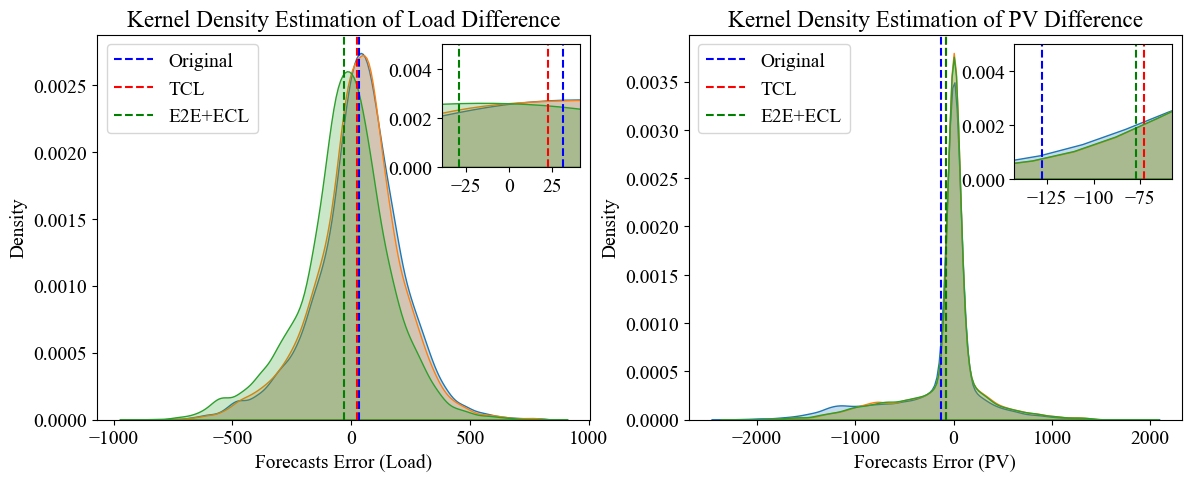

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import Rectangle
import numpy as np

plt.rcParams.update({'font.size': 14})

# 假设 targets_load_list 和 forecasts_load_org[0.5] 以及 forecasts_load[0.5] 已经定义
# 计算差值
difference_org_load = forecasts_load_org[0.5] - targets_load
difference_load = forecasts_load[0.5] - targets_load
difference_e2e_load = forecasts_load_e2e[0.5] - targets_load
difference_e2e_ecl_load = forecasts_load_e2e_ecl[0.5] - targets_load
difference_online_e2e_load = forecasts_load_online_e2e[0.5] - targets_load

# 计算差值的均值和方差
mean_difference_org_load = np.mean(difference_org_load)
mean_difference_load = np.mean(difference_load)
mean_difference_e2e_load = np.mean(difference_e2e_load)
mean_difference_e2e_ecl_load = np.mean(difference_e2e_ecl_load)
mean_difference_online_e2e_load = np.mean(difference_online_e2e_load)

# 输出标准差
print('load')
print('Std variance_difference_org_load:', np.sqrt(np.var(difference_org_load)))
print('Std variance_difference_load:', np.sqrt(np.var(difference_load)))
print('Std variance_difference_e2e_load:', np.sqrt(np.var(difference_e2e_load)))
print('Mean_difference_org_load:', mean_difference_org_load)
print('Mean_difference_load:', mean_difference_load)
print('Mean_difference_e2e_load:', mean_difference_e2e_load)

dic = {}
dic['Load'] = [mean_difference_org_load, mean_difference_load, mean_difference_e2e_load, mean_difference_e2e_ecl_load, mean_difference_online_e2e_load]

# PV 数据
difference_org_pv = forecasts_pv_org[0.5] - targets_pv
difference_pv = forecasts_pv[0.5] - targets_pv
difference_e2e_pv = forecasts_pv_e2e[0.5] - targets_pv
difference_e2e_ecl_pv = forecasts_pv_e2e_ecl[0.5] - targets_pv
difference_online_e2e_pv = forecasts_pv_online_e2e[0.5] - targets_pv

mean_difference_org_pv = np.mean(difference_org_pv)
mean_difference_pv = np.mean(difference_pv)
mean_difference_e2e_pv = np.mean(difference_e2e_pv)
mean_difference_e2e_ecl_pv = np.mean(difference_e2e_ecl_pv)
mean_difference_online_e2e_pv = np.mean(difference_online_e2e_pv)

variance_difference_pv = np.var(difference_pv)
variance_difference_org_pv = np.var(difference_org_pv)
variance_difference_e2e_pv = np.var(difference_e2e_pv)
variance_difference_e2e_ecl_pv = np.var(difference_e2e_ecl_pv)
variance_difference_online_e2e_pv = np.var(difference_online_e2e_pv)

print('PV')
print('Std variance_difference_org_pv:', np.sqrt(variance_difference_org_pv))
print('Mean_difference_org_pv:', mean_difference_org_pv)
print('Std variance_difference_pv:', np.sqrt(variance_difference_pv))
print('Mean_difference_pv:', mean_difference_pv)
print('Std variance_difference_e2e_pv:', np.sqrt(variance_difference_e2e_pv))
print('Mean_difference_e2e_pv:', mean_difference_e2e_pv)

dic['PV'] = [mean_difference_org_pv, mean_difference_pv, mean_difference_e2e_pv, mean_difference_e2e_ecl_pv, mean_difference_online_e2e_pv]

# 创建两个子图
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# 绘制 Load 图
sns.kdeplot(difference_org_load, shade=True, ax=ax1)
ax1.axvline(mean_difference_org_load, color='b', linestyle='--', label='Original')
sns.kdeplot(difference_load, shade=True, ax=ax1)
ax1.axvline(mean_difference_load, color='r', linestyle='--', label='TCL')
sns.kdeplot(difference_e2e_ecl_load, shade=True, ax=ax1)
ax1.axvline(mean_difference_e2e_ecl_load, color='g', linestyle='--', label='E2E+ECL')

ax1.set_title('Kernel Density Estimation of Load Difference')
ax1.set_xlabel('Forecasts Error (Load)')
ax1.set_ylabel('Density')
ax1.legend(loc='upper left')

x1_load = np.min([mean_difference_org_load, mean_difference_load, mean_difference_e2e_ecl_load]) - 10
x2_load = np.max([mean_difference_org_load, mean_difference_load, mean_difference_e2e_ecl_load]) + 10
y1_load, y2_load = 0, 0.005

# 添加放大子图
axins1 = inset_axes(ax1, width="28%", height="32%", loc='upper right')
axins1.set_xlim(x1_load, x2_load)
axins1.set_ylim(y1_load, y2_load)

sns.kdeplot(difference_org_load, ax=axins1, shade=True)
axins1.axvline(mean_difference_org_load, color='b', linestyle='--')
sns.kdeplot(difference_load, ax=axins1, shade=True)
axins1.axvline(mean_difference_load, color='r', linestyle='--')
sns.kdeplot(difference_e2e_ecl_load, ax=axins1, shade=True)
axins1.axvline(mean_difference_e2e_ecl_load, color='g', linestyle='--')

# 绘制 PV 图
sns.kdeplot(difference_org_pv, shade=True, ax=ax2)
ax2.axvline(mean_difference_org_pv, color='b', linestyle='--', label='Original')
sns.kdeplot(difference_pv, shade=True, ax=ax2)
ax2.axvline(mean_difference_pv, color='r', linestyle='--', label='TCL')
sns.kdeplot(difference_e2e_ecl_pv, shade=True, ax=ax2)
ax2.axvline(mean_difference_e2e_ecl_pv, color='g', linestyle='--', label='E2E+ECL')

ax2.set_title('Kernel Density Estimation of PV Difference')
ax2.set_xlabel('Forecasts Error (PV)')
ax2.set_ylabel('Density')
ax2.legend(loc='upper left')

x1_pv = np.min([mean_difference_org_pv, mean_difference_pv, mean_difference_e2e_ecl_pv]) - 15
x2_pv = np.max([mean_difference_org_pv, mean_difference_pv, mean_difference_e2e_ecl_pv]) + 15
y1_pv, y2_pv = 0, 0.005

# 添加放大子图
axins2 = inset_axes(ax2, width="32%", height="35%", loc='upper right')
axins2.set_xlim(x1_pv, x2_pv)
axins2.set_ylim(y1_pv, y2_pv)

sns.kdeplot(difference_org_pv, ax=axins2, shade=True)
axins2.axvline(mean_difference_org_pv, color='b', linestyle='--')
sns.kdeplot(difference_pv, ax=axins2, shade=True)
axins2.axvline(mean_difference_pv, color='r', linestyle='--')
sns.kdeplot(difference_e2e_ecl_pv, ax=axins2, shade=True)
axins2.axvline(mean_difference_e2e_ecl_pv, color='g', linestyle='--')
axins1.set_ylabel('')
axins2.set_ylabel('')
plt.savefig('../Figure/parameter/difference'+str(int(args_train.flag_dynamic_price))+str(args_train.flag_dynamic_mode)+'.png')
plt.show()

In [ ]:
if args_train.flag_dynamic_price:
    mean_result=pd.DataFrame(dic).T
    mean_result.columns=['Original','TCL','E2E','E2E+ECL','ECL']
    mean_result.to_csv('../Result/parameter/Mean_difference_dynamic_price'+str(int(args_train.flag_dynamic_price))+str(args_train.flag_dynamic_mode)+'.csv')